In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import os

import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import ImageGrid

print('Cuda available: ' + str(torch.cuda.is_available()))
print('Cuda version: ' + str(torch.version.cuda))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Cuda available: True
Cuda version: 10.2


Count:0
Count:200
Count:400
Count:600
Count:800
Count:1000
Count:1200
Count:1400
Data size: 1600


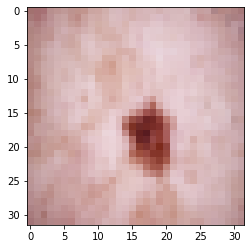

In [3]:
data_size = 100
batch_size = 16
latent_dim = 10
im_width = 32
im_height = 32

EPS = 1e-6
ALPHA_RECONSTRUCT_IMAGE = 1
ALPHA_RECONSTRUCT_LATENT = 0.5
ALPHA_DISCRIMINATE_IMAGE = 0.005
ALPHA_DISCRIMINATE_LATENT = 0.1

# Load images
images = []
folder = 'HAM10000_images_part_1'
count = 0
for filename in os.listdir(folder):
    
    if count == data_size * batch_size:
        break
    if count%200 == 0:
        print('Count:' + str(count), flush=True)
    count+=1
    
    img = cv2.imread(os.path.join(folder,filename))
    img = cv2.resize(img, (im_width, im_height), interpolation = cv2.INTER_AREA)
    images.append(img)
print('Data size: ' + str(len(images)))

data = images[:data_size*batch_size]
data = np.array(data)
data = torch.from_numpy(data)
data = data.view(data_size, batch_size, 3, im_width, im_height)
img_sample = data[0][0].view(im_width, im_height, 3).numpy()
plt.imshow(cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB))

In [4]:
class Generator(nn.Module): # latent (b x latent_dim x 1 x 1) -> image (b x 3 x im_width x im_height)
    def __init__(self):
        super(Generator, self).__init__()
        self.op1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(latent_dim, 1024, 3, 1, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True)
        )
        
        self.op2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(1024, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        
        self.op3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(512, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        
        self.op4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(256, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        
        self.op5 = nn.Sequential(    
            nn.ConvTranspose2d(128, 3, 2, 2, 0),
            nn.ReLU(True),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(batch_size, latent_dim, 1, 1)
        x = self.op1(x)
        x = self.op2(x)
        x = self.op3(x)
        x = self.op4(x)
        x = self.op5(x)
        return x

In [5]:
 class Encoder(nn.Module): # image (b x 3 x 32 x 32) -> latent (b x latent_dim x 1 x 1) 
        
    def __init__(self):
        super(Encoder, self).__init__()
        self.op1 = nn.Sequential(
            nn.Conv2d(3, 256, 2, 2, 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.op2 = nn.Sequential(
            nn.Conv2d(256, 512, 2, 2, 0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.op3 = nn.Sequential(
            nn.Conv2d(512, 256, 2, 2, 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.op4 = nn.Sequential(
            nn.Conv2d(256, 128, 2, 2, 0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.op5 = nn.Sequential(
            nn.Conv2d(128, latent_dim, 2, 2, 0),
            nn.BatchNorm2d(latent_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(p=0.2),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(batch_size, 3, im_height, im_width).float()
        x = self.op1(x)
        x = self.op2(x)
        x = self.op3(x)
        x = self.op4(x)
        x = self.op5(x)
        return x

In [6]:
class DiscriminatorImage(nn.Module): # (b x 3 x 32 x 32) -> 0-1
    def __init__(self):
        super(DiscriminatorImage, self).__init__()
        
        self.op1 = nn.Sequential (
            nn.Conv2d(3, 32, 2, 2, 0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )
        self.op2 = nn.Sequential (
            nn.Conv2d(32, 64, 2, 2, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        self.op3 = nn.Sequential (
            nn.Conv2d(64, 128, 2, 2, 0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.op4 = nn.Sequential (
            nn.Conv2d(128, 256, 2, 2, 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self.op5 = nn.Sequential (
            nn.Conv2d(256, 1, 2, 2, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(batch_size, 3, im_width, im_height).float()
        x = self.op1(x)
        x = self.op2(x)
        x = self.op3(x)
        x = self.op4(x)
        x = self.op5(x)
        return x

In [7]:
class DiscriminatorLatent(nn.Module): # (b x latent x 1 x 1) -> 0-1
    def __init__(self):
        super(DiscriminatorLatent, self).__init__()
        self.op1 = nn.Sequential(
            nn.Linear(latent_dim, 32, bias=True),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2)
        )
        self.op2 = nn.Sequential(
            nn.Linear(32, 16, bias=True),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2)
        )
        self.op3 = nn.Sequential(
            nn.Linear(16, 8, bias=True),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2)
        )
        self.op4 = nn.Sequential(
            nn.Linear(8, 1, bias=True),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(batch_size, latent_dim)
        x = self.op1(x)
        x = self.op2(x)
        x = self.op3(x)
        x = self.op4(x)
        x = x.view(batch_size, 1, 1, 1)
        return x

In [8]:
# Cell code used from: https://github.com/ConorLazarou/PokeGAN/blob/master/aegan.py
class Gan():
    
    def __init__(self, batch_size, device):
        self.batch_size = batch_size
        self.device = device
        
        self.criterion_g = nn.BCELoss()
        self.criterion_r_x = nn.L1Loss()
        self.criterion_r_z = nn.MSELoss()
        
        self.lr = 0.0005
        self.betas = (0.5, 0.99)

        self.true_label = torch.full((batch_size,), 0.95, dtype=torch.float, device=device)
        self.false_label = torch.full((batch_size,), 0.05, dtype=torch.float, device=device)
        self.true_label = self.true_label.view(batch_size, 1, 1, 1)
        self.false_label = self.false_label.view(batch_size, 1, 1, 1)
        
        self.init_generator()
        self.init_encoder()
        self.init_discriminator_x()
        self.init_discriminator_z()
    
    def init_generator(self):
        self.gen = Generator().to(self.device)
        self.opt_gen = optim.Adam(self.gen.parameters(), lr=self.lr, betas=self.betas)

    def init_encoder(self):
        self.enc = Encoder().to(self.device)
        self.opt_enc = optim.Adam(self.enc.parameters(), lr=self.lr, betas=self.betas)

    def init_discriminator_x(self):
        self.disc_x = DiscriminatorImage().to(self.device)
        self.opt_disc_x = optim.Adam(self.disc_x.parameters(), lr=self.lr, betas=self.betas)

    def init_discriminator_z(self):
        self.disc_z = DiscriminatorLatent().to(self.device)
        self.opt_disc_z = optim.Adam(self.disc_z.parameters(), lr=self.lr, betas=self.betas)
        
    def generate_images(self, latent_vector=None):
        latent_vector = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        
        
    def train_generator(self, x):
        self.gen.zero_grad()
        self.enc.zero_grad()
        
        z = torch.randn(self.batch_size, latent_dim, 1, 1, device=device)
        
        x1 = self.gen(z)
        z1 = self.enc(x)
        x2 = self.gen(z1)
        z2 = self.enc(x1)
        
        x1_confidence = self.disc_x(x1)
        z1_confidence = self.disc_z(z1)
        x2_confidence = self.disc_x(x2)
        z2_confidence = self.disc_z(z2)
        
        x1_loss = self.criterion_g(x1_confidence, self.true_label)
        z1_loss = self.criterion_g(z1_confidence, self.true_label)
        x2_loss = self.criterion_g(x2_confidence, self.true_label)
        z2_loss = self.criterion_g(z2_confidence, self.true_label)
        
        x_recon_loss = self.criterion_r_x(x2, x) * ALPHA_RECONSTRUCT_IMAGE
        z_recon_loss = self.criterion_r_z(z2, z) * ALPHA_RECONSTRUCT_LATENT
        
        x_loss = (x1_loss + x2_loss) / 2. * ALPHA_DISCRIMINATE_IMAGE
        z_loss = (z1_loss + z2_loss) / 2. * ALPHA_DISCRIMINATE_LATENT
        loss = x_loss + z_loss + x_recon_loss + z_recon_loss
        
        loss.backward()
        self.opt_enc.step()
        self.opt_gen.step()
        
        return x_loss.item(), z_loss.item(), x_recon_loss.item(), z_recon_loss.item()
    
    def train_discriminator(self, x):
        self.disc_x.zero_grad()
        self.disc_z.zero_grad()
    
        z = torch.randn(self.batch_size, latent_dim, 1, 1, device=device)
        
        with torch.no_grad():                              
            x1 = self.gen(z)
            z1 = self.enc(x)
            x2 = self.gen(z1)
            z2 = self.enc(x1)
        
        
        x_confidence = self.disc_x(x)
        z_confidence = self.disc_z(z)
        x1_confidence = self.disc_x(x1)
        z1_confidence = self.disc_z(z1)
        x2_confidence = self.disc_x(x2)
        z2_confidence = self.disc_z(z2)
        
        x_loss = 2 * self.criterion_g(x_confidence, self.true_label)
        z_loss = 2 * self.criterion_g(z_confidence, self.true_label)
        x1_loss = self.criterion_g(x1_confidence, self.false_label)
        z1_loss = self.criterion_g(z1_confidence, self.false_label)
        x2_loss = self.criterion_g(x2_confidence, self.false_label)
        z2_loss = self.criterion_g(z2_confidence, self.false_label)
        
        loss_images = (x_loss + x1_loss + x2_loss) / 4.
        loss_latent = (z_loss + z1_loss + z2_loss) / 4.
        loss = loss_images + loss_latent
        
        loss.backward()
        self.opt_disc_x.step()
        self.opt_disc_z.step()
        
        return loss_images.item(), loss_latent.item()
        
    def train_epoch(self, data):
        
        ldx, ldz, lgx, lgz, lrx, lrz = 0, 0, 0, 0, 0, 0
        eps = 1e-9
        
        for i, data in enumerate(data):
            data = data.to(self.device)
            ldx_, ldz_ = self.train_discriminator(data)
            ldx += ldx_
            ldz += ldz_
            lgx_, lgz_, lrx_, lrz_ = self.train_generator(data)
            lgx += lgx_
            lgz += lgz
            lrx += lrx_
            lrz += lrz_
        lgx /= i
        lgz /= i
        ldx /= i
        ldz /= i
        lrx /= i
        lrz /= i
        return lgx, lgz, ldx, ldz, lrx, lrz

In [9]:
def make_image(gan, add=True):
    img_batch = gan.gen(fixed_noise)[:25]
    img_list.append(img_batch)
    
def make_animation():
    img_list_anim = []
    
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    count = 0
    
    for batch in img_list:
        grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
        print(count, end="\r")
        count+=1
        
        for ax, img in zip(grid, batch):
            img = img.view(32, 32, 3).cpu().detach().numpy()
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.axis("off")
            
        img_list_anim.append(grid)
    anim = animation.ArtistAnimation(fig, img_list_anim, interval=1000, repeat_delay=1000)
    return anim

In [10]:
epochs = 150
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
img_list = []
gan = Gan(batch_size, device)

for i in range(epochs):
    print('Epoch: ' + str(i), end="\r")
    if i%8==0:
        make_image(gan)
    gan.train_epoch(data)

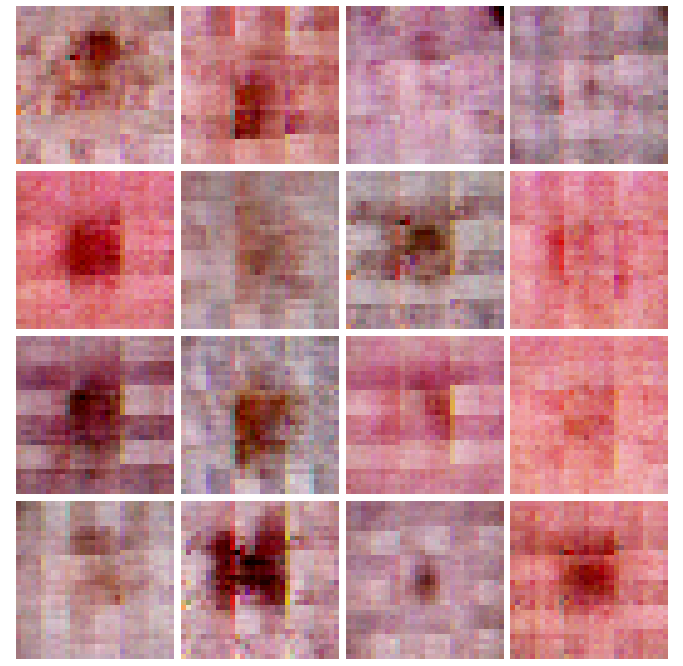

In [11]:
noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
batch = gan.gen(noise)

fig = plt.figure(figsize=(12, 12))
plt.axis("off")
grid = ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.1)

for ax, img in zip(grid, batch):
    img = img.view(32, 32, 3).cpu().detach().numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis("off")
plt.show()

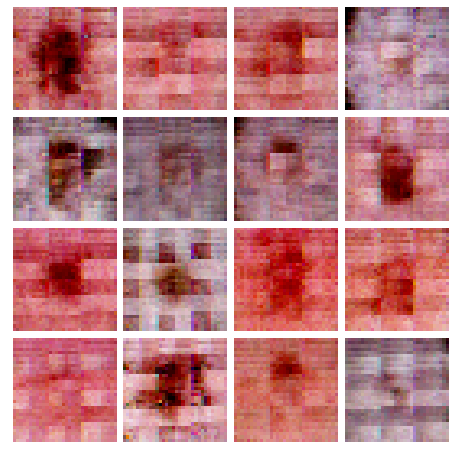

In [12]:
ANIM_PATH = 'Animation.gif'
anim = make_animation()
anim.save(ANIM_PATH, fps=5)
HTML(anim.to_html5_video())